In [2]:
import pandas as pd
import datetime as dt
import yfinance as yf
import scipy as sci
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np

In [3]:

# get stock data from past two year
start_date = dt.datetime.today() - dt.timedelta(days = 365 * 2)
end_date = dt.datetime.today()

# symbols for Microsoft (MSFT) and Apple (AAPL)
tickers = ['MSFT', 'AAPL', 'AMD', 'IBM', 'INTC', 'NVDA']

# download data 
stock = yf.download(tickers, start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  6 of 6 completed


In [4]:
daily_log_return = np.log((stock['Close'] / stock['Close'].shift(1)).dropna())

# Analysis on the moments
One intuitive way to test the normality is to compare the moments of the probability distribution. The first two order moments are essentially the mean and variance of the distribution, which gives the location and scale of the distribution. To further characterize the shape of the distribution, higher order moments is required, which leads to the concept of skewness and kurtosis.
## skewness
For a random variable $X$ with $E(|X|^3)<\infty$, its skewness is defined as third order standardized moments
$$
\gamma_1=E\left[\frac{(X-\mu)^3}{\sigma^3}\right]
$$
where $\mu=E[X]$ is the first order moment (mean), and $\sigma^2$ is the centered second order moment (variance). Typically for a unimodal distribution (only one peak), the skewness characterize whether the distribution is symmetric (skewness=0), left tailed (skewness<0) and right tailed (skewness>0).

Noticed these rules fails for multimodal distribution or in the cased where the tailed is extremely long and the other are very heavy.


## Kurtosis
For a random variable $X$ with $E(|X|^4)<\infty$, the kurtosis is defined a 4th order standardized moments
$$
\gamma_2=E\left[\frac{(X-\mu)^4}{\sigma^4}\right]
$$
For $X\sim\mathcal{N}(0, 1)$, its kurtosis can be found through integration by part as 3. The excess kurtosis is defined as $\gamma_2-3$. Therefore, if a distribution is similar to normal distribution, its excess kurtosis should be close to zero. 

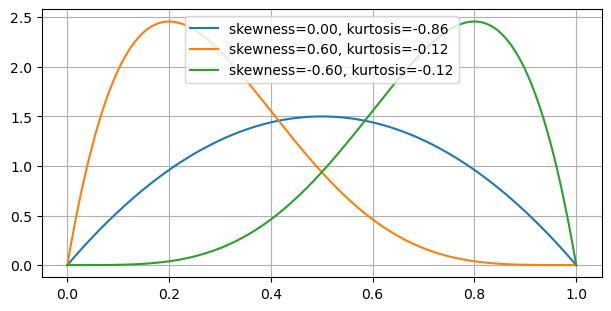

In [5]:
fig1, ax1 = plt.subplots(1, 1, figsize=[6, 3], layout='constrained')
x = np.linspace(0, 1, 1000)
skew, kurt = beta.stats(2, 2, moments='sk') 
ax1.plot(x, beta.pdf(x, 2, 2), label=f'skewness={skew:.2f}, kurtosis={kurt:.2f}')
skew, kurt = beta.stats(2, 5, moments='sk')
ax1.plot(x, beta.pdf(x, 2, 5), label=f'skewness={skew:.2f}, kurtosis={kurt:.2f}')
skew, kurt = beta.stats(5, 2, moments='sk')
ax1.plot(x, beta.pdf(x, 5, 2), label=f'skewness={skew:.2f}, kurtosis={kurt:.2f}')
ax1.legend()
ax1.grid('on')

## Sample estimation
In practice, we need to estimate the skewness and kurtosis using finite samples. The estimators for skewness and kurtosis is defined by replacing the mean with sample mean $\bar{X}$ and variance as maximum likelihood estimated variance ${s^\prime}^2=\frac{1}{n}\sum(X_j-\bar{X})^2$ (notice the is not this is not the sample variance as it not unbiased). 

The sample skewness $r_1$ is defined as
$$
r_1=\frac{1}{n}\sum_{j=1}^n\frac{(X_j-\bar{X})^3}{(s^\prime)^3}
$$
and sample excess kurtosis is
$$
r_2=\frac{1}{n}\sum_{j=1}^n\frac{(X_j-\bar{X})^4}{(s^\prime)^4} - 3
$$


## Test on the normality of log returns of different stocks
We now calculate the sample skewness and kurtosis for the stocks we selected

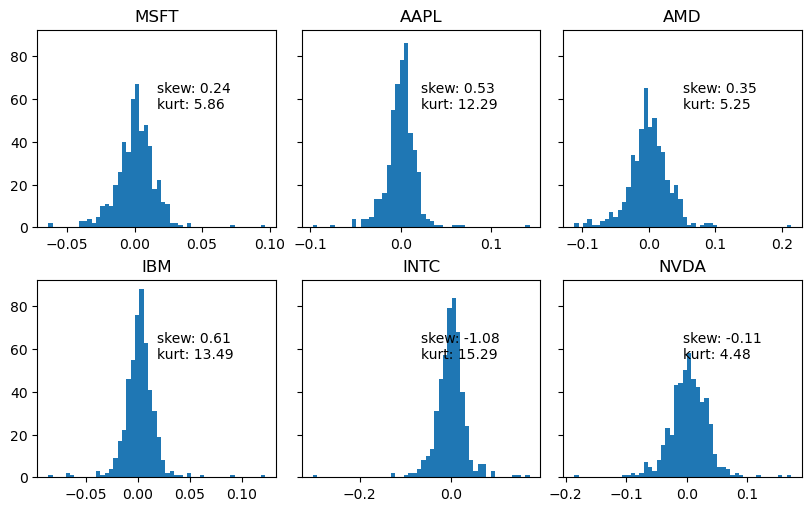

In [34]:
fig2, axs2 = plt.subplots(2, len(tickers)//2, figsize = [8, 5], layout='constrained', sharey=True)
for ax, ticker in zip(axs2.flat, tickers):
    ax.hist(daily_log_return[ticker], bins=50)
    s = sci.stats.skew(daily_log_return[ticker])
    k = sci.stats.kurtosis(daily_log_return[ticker])
    ax.set_title(ticker)
    ax.text(x=0.5, y=0.6, s=f'skew: {s:.2f}\nkurt: {k:.2f}', transform=ax.transAxes)


Among the six different stocks we have selected, most of them shows strong deviance in skewness and kurtosis with normal. 

# The Jarque-Bera test
The above calculation on the sample skewness and kurtosis gives a intuitive examination on the normality of the distribution. However, we still wish to have a formal hypothesis test based on this idea. The statistics used for testing is called *Jarque-Bera statistics*
$$
J=\frac{n}{6}\left(r_1^2+\frac{1}{4}r_2^2\right)
$$
It can be shown that as $n$ becomes large, and samples comes from a normal distribution, $J$ converges to a $\chi^2$ distribution with degrees of freedom of 2.
As both the skewness and kurtosis deviate from 0 as the testing distribution deviate from normal, the null hypothesi is rejected when the test statistics is large. 

In [7]:
for ticker in tickers:
    test_result = sci.stats.jarque_bera(daily_log_return[ticker])
    print(f"{ticker} -- test statistics: {test_result.statistic:.2f} p-value: {test_result.pvalue:.2f}")


MSFT -- test statistics: 720.35 p-value: 0.00
AAPL -- test statistics: 3178.92 p-value: 0.00
AMD -- test statistics: 585.89 p-value: 0.00
IBM -- test statistics: 3831.14 p-value: 0.00
INTC -- test statistics: 4976.33 p-value: 0.00
NVDA -- test statistics: 419.08 p-value: 0.00


The test shows that for all of the stocks chosen, there is enough evidence to reject null hypothesis that the log return are normally distributed, which coincide with the our previous conclusion from skewness and kurtosis. 

# Quantile-Quantile (Q-Q) plots

Quantile-Quantile plot or Q-Q plot provided an way for normality test graphically. The Q-Q plot, in general, can be used to comparing the similarity of the population distributions from two sample sets, two known distribution functions or comparing a dataset to a specific distribution function. 

Suppose we have two i.i.d. dataset of the same size $\{X_1, X_2, \cdots, X_n\}$ and $\{Y_1, Y_2, \cdots, Y_n\}$. The Q-Q plot is constructed by plotting the order statistics of $\{X_i\}$ against that of $\{Y_i\}$. More specifically, suppose their order statistics are denoted as $X_{(1)}\leq X_{(2)}\leq\cdots\leq X_{(n)}$ and $Y_{(1)}\leq Y_{(2)}\leq\cdots\leq Y_{(n)}$, we then draw the plots in data pair $(X_{(i)}, Y_{(i)})$.
* If $\{X_i\}$ and $\{Y_i\}$ are sampled from the same distribution, and $n$ is large enough, the Q-Q plot will be approximately on the line $y=x$.
* If the underlying distribution of $X$ and $Y$ are belongs two a location-scale family (like $\mathcal{N}(0, 1)$ and $\mathcal{N}(\mu, \sigma^2)$), the Q-Q plot will be approximately a line in general case.

For comparing two distribution function, suppose we have the CDF for each distribution as $F_1, F_2$. The *quantile function* is essentially the inverse of the CDF $F^{-1}_1, F^{-1}_2$. The Q-Q plot is drawn by taking a range of quantile levels for $F^{-1}_1$ and $F^{1}_1$. 

To comparing the population distribution of a dataset $X_1, X_2, \cdots, X_n$ to a specific probability distribution with CDF $F$, one can constructed a plot through points $(X_{(i)}, y_i)$ where $y_i=F^{-1}(i/(n+1))$ is the theoretical quantile. 
* Suppose $X_i$ are i.i.d. from a probability distribution with CDF $G(x)$. We can estimate the CDF at $i$ th order statistic observed value $G(x_{(i)})=P(X\leq x_{(i)})$ simply as the number of samples that is less than $x_{(i)}$, which gives the estimated probability as $i/(n+1)$. $n+1$ is used so that the probability is not 1 for $x_{(n)}$ case.

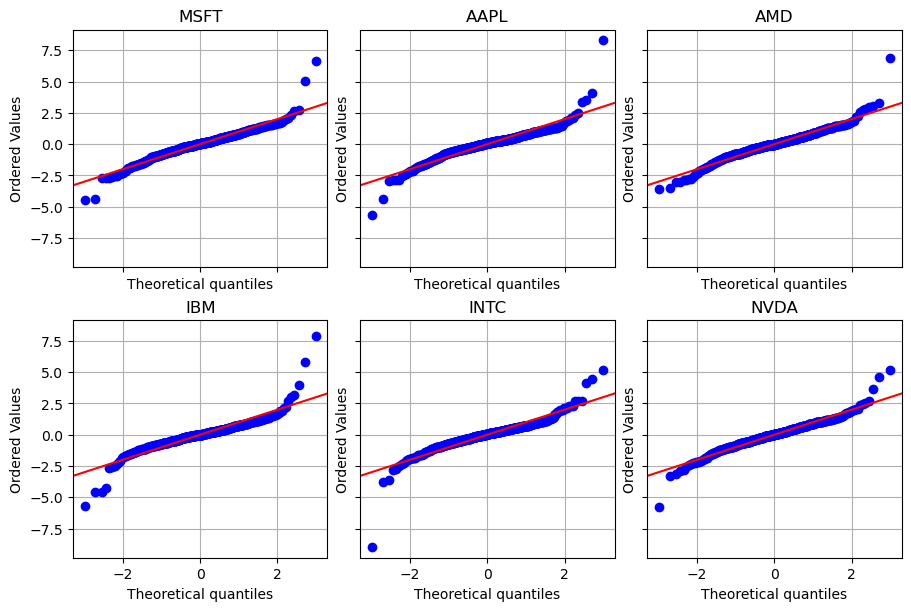

In [ ]:
fig3, axs3 = plt.subplots(2, len(tickers)//2, figsize=[9, 6], layout='constrained', sharex=True, sharey=True)
for ax, ticker in zip(axs3.flat, tickers):
    # standardize the data
    data_stand = (daily_log_return[ticker] - np.mean(daily_log_return[ticker]))/np.std(daily_log_return[ticker])
    sci.stats.probplot(data_stand, fit=False, dist=sci.stats.norm(), plot=ax)
    ax.set_title(ticker)
    ax.axline((-2, -2), slope=1, color='r')
    ax.grid('on')
    

# Shapiro-Wilk test
The Shapiro-Wilk is one of the frequentest used normality test. The idea behind the test is closely related to the Q-Q plot. 

Suppose we have a dataset $X_1, X_2, \cdots, X_n$ and its order statistics $X_{(1)}\leq X_{(2)}\leq\cdots\leq X_{(2)}$. We wish to compare the data distribution with normal distribution. Let $Y_1, Y_2,\cdots, Y_n$ be i.i.d. samples from $\mathcal{N}(0, 1)$ and $Y_{(1)}\leq Y_{(2)}\leq\cdots\leq Y_{(n)}$ be its order statistics. Similar to the Q-Q plot, we wish to compare each pair of points $(X_{(i)}, Y_{(i)})$. This can be quantified by considering the correlation between $(X_{(1)}, \cdots, X_{(n)})$ and mean (location) of the $\{Y_{(i)}\}$, i.e. $(m_1, m_2,\cdots, m_n)=(E(Y_{(1)}), E(Y_{(2)}), \cdots, E(Y_{(n)}))$.
* A correlation close to 1 would suggesting a good fit to normality
* The idea can be interpreted as how well the sample ordered statistics follows the location of that in normal distribution

In the Shapiro-Wilk test, not only the location (mean) but also the scale of the normal order statistics (covariance and variance) is considered in the correlations. The null hypothesis for the test is 
$$
H_0:\text{The samples $X_1, X_2, \cdots, X_n$ come from a normally distributed population.}
$$
and the test statistics is
$$
W=\frac{\left(a_iX_{(i)}\right)^2}{\sum_{i=1}^n(X_i-\bar{X})^2}
$$
where is normalized vector contracted by the mean vector $\mathbb{m}$ and covariance matrix $V$ of the order statistics of iid samples from standard normal distribution $\{Y_{(i)}\}$, more specifically as
$$
(a_1, a_2, \cdots, a_n)=\frac{\mathbb{m}^TV^{-1}}{\|V^{-1}\mathbb{m}\|}
$$
The test statistics is in a correlation form between $X_{(i)}$ and $a_i$, and we expected the correlation to be 1 if the data are actually sampled from normal distribution. Therefore, we would reject the null hypothesi if the test statistics is small. 

MSFT -- test statistics: 0.94 p-value: 0.00
AAPL -- test statistics: 0.89 p-value: 0.00
AMD -- test statistics: 0.95 p-value: 0.00
IBM -- test statistics: 0.86 p-value: 0.00
INTC -- test statistics: 0.88 p-value: 0.00
NVDA -- test statistics: 0.95 p-value: 0.00


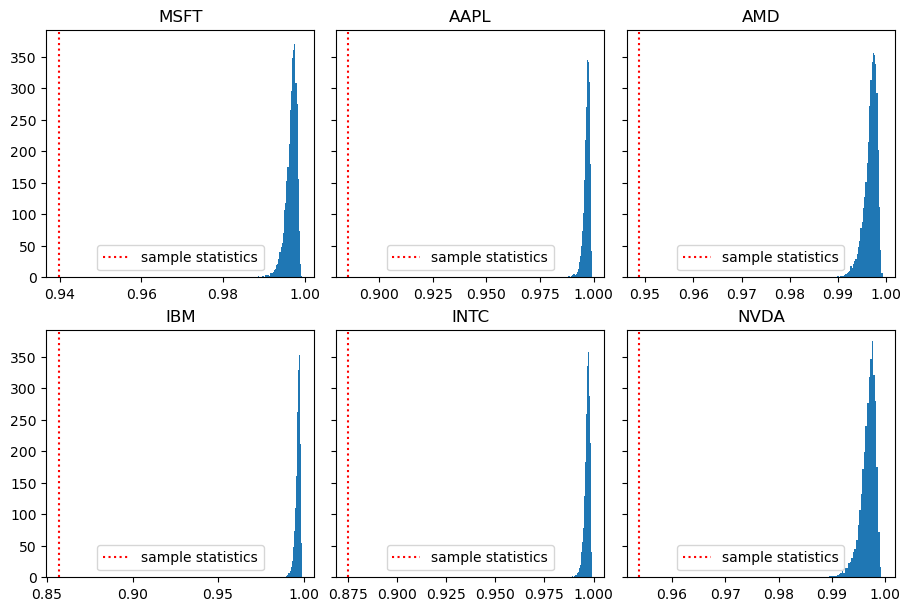

In [ ]:
def statistic(x):
    # Get only the `shapiro` statistic; ignore its p-value
    return sci.stats.shapiro(x).statistic
fig4, axs4 = plt.subplots(2, len(tickers)//2, figsize=[9, 6], layout='constrained', sharey=True)
for ax, ticker in zip(axs4.flat, tickers):
    test_result = sci.stats.shapiro(daily_log_return[ticker])
    # get the test statistics from the monte-carlo sampling
    ref = sci.stats.monte_carlo_test(daily_log_return[ticker], sci.stats.norm.rvs, statistic, alternative='less')
    ax.hist(ref.null_distribution, density=True, bins=50)
    ax.set_title(ticker)
    ax.axvline(test_result.statistic, c='r', ls=':', label='sample statistics')
    ax.legend()

    print(f"{ticker} -- test statistics: {test_result.statistic:.2f} p-value: {test_result.pvalue:.2f}")


The p-value from the test is almost 0, and there for we reject the null hypothesis and conclude that there is significant evidence from the data that the log return of all 6 stocks does not follow normal distribution. 